In [6]:
# import os
# import sys
# import numpy as np
# import pandas as pd
# import seaborn as sns
# from glob import glob
# import tensorflow as tf
# import keras

# %matplotlib inline
# import matplotlib.pyplot as plt
# from keras.src.layers import Input 
# from keras import Sequential, Model
# from tensorflow.keras.metrics import BinaryAccuracy
# from keras.saving import register_keras_serializable
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report,confusion_matrix
# from keras.src.layers  import Dropout, Dense, LayerNormalization, Input
# from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

# os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import keras_tuner as kt   # keras_tuner hỗ trợ tf.keras 
from tensorflow.keras import Sequential, Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.saving import register_keras_serializable
from tensorflow.keras.layers import Input, Dropout, Dense, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, CSVLogger

# Tắt OneDNN (tránh warning trên CPU Intel)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

In [9]:
train_data_dir = '../Dataset_Final/train/'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
# print(folds)

for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')

train_df = pd.concat([Fseries, Lseries], axis= 1)

In [11]:
test_data_dir = '../Dataset_Final/test/'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [14]:
val_data_dir = '../Dataset_Final/val/'
filepaths = []
labels = []
folds = os.listdir(val_data_dir)
for fold in folds:
    foldpath = os.path.join(val_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        fpath = fpath.replace("\\", "/")
        
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
valid_df = pd.concat([Fseries, Lseries], axis= 1)
train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)

In [16]:
df = pd.read_csv('metadata.csv')

C:\Users\hp\AppData\Local\Temp\ipykernel_27676\955804050.py:1: DtypeWarning: Columns (7,12,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('metadata.csv')


In [18]:
df

,isic_id,attribution,copyright_license,acquisition_day,age_approx,anatom_site_general,clin_size_long_diam_mm,concomitant_biopsy,diagnosis_1,diagnosis_2,...,tbp_tile_type,anatom_site_special,family_hx_mm,melanocytic,personal_hx_mm,dermoscopic_type,mel_ulcer,fitzpatrick_skin_type,diagnosis_processed,dataset_split
0,ISIC_0906377,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,18814.0,65.0,anterior torso,4.97,False,Benign,NaN,...,3D: XP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,train
1,ISIC_6566420,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,33064.0,60.0,upper extremity,3.98,False,Benign,NaN,...,3D: XP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,test
2,ISIC_2556770,"Frazer Institute, The University of Queensland...",CC-BY,29360.0,60.0,lower extremity,3.46,NaN,Benign,NaN,...,3D: XP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,train
3,ISIC_2318640,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,366.0,45.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,...,NaN,NaN,NaN,True,NaN,contact polarized,NaN,NaN,Benign,train
4,ISIC_6088379,Title: ISIC 2024 Basel \r\nSource: University ...,CC-BY-NC,NaN,55.0,upper extremity,2.70,NaN,Benign,NaN,...,3D: XP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Benign,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49429,ISIC_9430252,Memorial Sloan Kettering Cancer Center,CC-0,2864.0,65.0,lateral torso,8.40,True,Indeterminate,Indeterminate melanocytic proliferations,...,NaN,NaN,True,True,True,contact polarized,NaN,II,Malignant,test
49430,ISIC_9569039,Memorial Sloan Kettering Cancer Center,CC-0,1.0,60.0,head/neck,5.20,True,Indeterminate,Indeterminate melanocytic proliferations,...,NaN,NaN,True,True,False,contact polarized,NaN,II,Malignant,train
49431,ISIC_9595615,Memorial Sloan Kettering Cancer Center,CC-0,1.0,85.0,head/neck,3.60,True,Indeterminate,Indeterminate epidermal proliferations,...,NaN,NaN,False,False,False,contact polarized,NaN,III,Malignant,train
49432,ISIC_9615486,Memorial Sloan Kettering Cancer Center,CC-0,1.0,55.0,posterior torso,NaN,True,Malignant,Malignant epidermal proliferations,...,NaN,NaN,True,False,True,NaN,NaN,II,Malignant,train


In [20]:
df['diagnosis_processed'] = df['diagnosis_processed'].apply(lambda x: 0 if x == 'Benign' else 1)

In [22]:
train_df = df[df['dataset_split'] == 'train']  
valid_df = df[df['dataset_split'] == 'val'] 
test_df = df[df['dataset_split'] == 'test']  

In [24]:
print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(valid_df)}")
print(f"Test size: {len(test_df)}")

Train size: 34603
Validation size: 4450
Test size: 10381


In [26]:
test_labels = test_df['diagnosis_processed'].values 
print('train', train_df.shape[0], 'validation', valid_df.shape[0], 'test', test_df.shape[0],'test_diagnosis_processed', test_labels.shape[0])

train 34603 validation 4450 test 10381 test_diagnosis_processed 10381


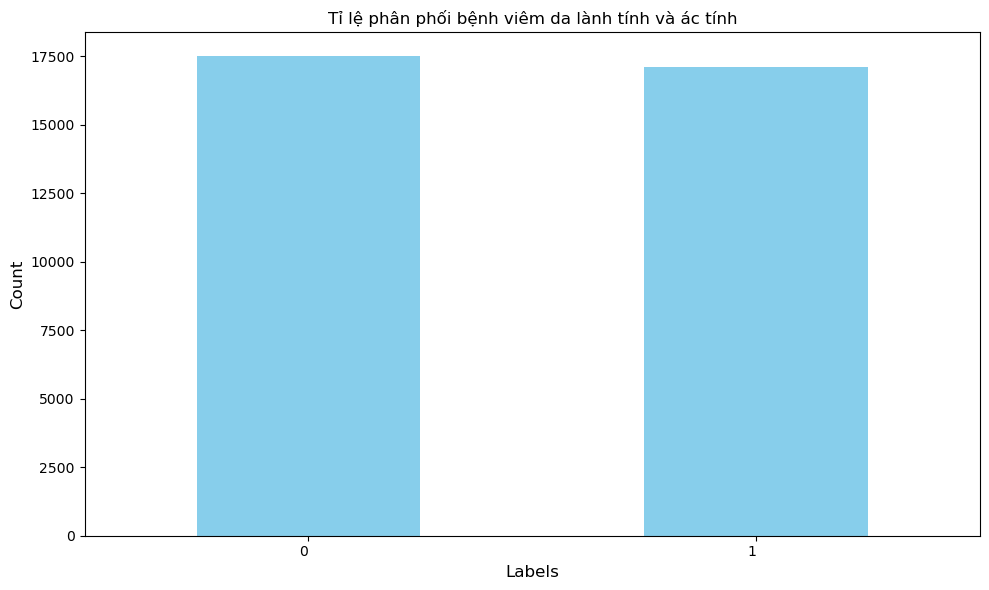

In [28]:
label_counts = train_df['diagnosis_processed'].value_counts()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar', color= 'skyblue')
plt.title('Tỉ lệ phân phối bệnh viêm da lành tính và ác tính')
plt.xlabel('Labels', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# THAY ĐỔI KÍCH THƯỚC ẢNH
IMG_SIZE = (32, 32)  
TRAIN_BATCH_SIZE = 32
VALID_TEST_BATCH_SIZE = 32

# core_idg = ImageDataGenerator(
#                             rescale=1./255,
#                               horizontal_flip=True,
#                               vertical_flip=False,
#                               height_shift_range=0.2,
#                               width_shift_range=0.2,
#                               rotation_range=40,
#                               shear_range=0.2,
#                               fill_mode='reflect',
#                               zoom_range=0.2
#                              )

train_dir = '../Dataset_Final/train/'
valid_dir = '../Dataset_Final/val/'
test_dir = '../Dataset_Final/test/'

# Data generator cho training với augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Chuẩn hóa pixel values về [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

# Data generator cho validation và test (chỉ rescale)
valid_test_datagen = ImageDataGenerator(rescale=1./255)

In [32]:
# Cập nhật generators với kích thước mới
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,  # Sửa thành 224x224
    batch_size=TRAIN_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    seed=42
)

Found 34603 images belonging to 2 classes.


In [33]:
valid_gen = valid_test_datagen.flow_from_directory(
    valid_dir,
    target_size=IMG_SIZE,  # Sửa thành 224x224
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 4450 images belonging to 2 classes.


In [36]:
test_gen = valid_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,  # Sửa thành 224x224
    batch_size=VALID_TEST_BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 10381 images belonging to 2 classes.


In [38]:
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")

Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325


In [40]:
# Kiểm tra kết quả
print("Training generator:")
print(f"Classes: {train_gen.class_indices}")
print(f"Samples: {train_gen.samples}")
print(f"Batch size: {train_gen.batch_size}")
print(f"Number of batches: {len(train_gen)}")

# Đếm số lượng mẫu cho mỗi class trong training
if hasattr(train_gen, 'classes'):
    train_classes = train_gen.classes
    unique, counts = np.unique(train_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in train_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Validation generator:")
print(f"Classes: {valid_gen.class_indices}")
print(f"Samples: {valid_gen.samples}")
print(f"Batch size: {valid_gen.batch_size}")
print(f"Number of batches: {len(valid_gen)}")

if hasattr(valid_gen, 'classes'):
    valid_classes = valid_gen.classes
    unique, counts = np.unique(valid_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in valid_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")
print("\n")

print("Test generator:")
print(f"Classes: {test_gen.class_indices}")
print(f"Samples: {test_gen.samples}")
print(f"Batch size: {test_gen.batch_size}")
print(f"Number of batches: {len(test_gen)}")

if hasattr(test_gen, 'classes'):
    test_classes = test_gen.classes
    unique, counts = np.unique(test_classes, return_counts=True)
    print("Samples per class:")
    for class_idx, count in zip(unique, counts):
        class_name = [name for name, idx in test_gen.class_indices.items() if idx == class_idx][0]
        print(f"  {class_name}: {count}")

Training generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 34603
Batch size: 32
Number of batches: 1082
Samples per class:
  Benign: 17500
  Malignant: 17103


Validation generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 4450
Batch size: 32
Number of batches: 140
Samples per class:
  Benign: 2250
  Malignant: 2200


Test generator:
Classes: {'Benign': 0, 'Malignant': 1}
Samples: 10381
Batch size: 32
Number of batches: 325
Samples per class:
  Benign: 5250
  Malignant: 5131


In [42]:
def process_train_gen(train_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(train_gen)
      
        yield x_batch, y_batch

def process_valid_test_gen(valid_test_gen):
    # Duyệt qua từng batch trong train_gen
    while True:
        x_batch, y_batch = next(valid_test_gen)
        
        yield x_batch, y_batch

train_gen = process_train_gen(train_gen)
valid_gen = process_valid_test_gen(valid_gen)
test_gen = process_valid_test_gen(test_gen)

In [44]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# kernel_regularizer = l2(0.001)
# from tensorflow.keras.regularizers import l2 
from keras.src.layers import Layer, Dense
import keras as kr
import tensorflow as tf

class Patches (Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]

    patches = tf.image.extract_patches(
      images=images,
      sizes=[1, self.patch_size, self.patch_size, 1],
      strides=[1, self.patch_size, self.patch_size, 1],
      rates=[1, 1, 1, 1],
      padding='VALID'
    )

    dim = patches.shape[-1]

    patches = tf.reshape(patches, (batch_size, -1, dim))

    return patches
  
class PatchEmbedding(Layer):
  def __init__(self, patch_size, image_size, projection_dim):
    super(PatchEmbedding, self).__init__()

    self.num_patches = (image_size // patch_size) ** 2

    self.cls_token = self.add_weight(
      name="cls_token",
      shape=[1, 1, projection_dim],
      initializer= kr.initializers.RandomNormal(),
      dtype= tf.float32
    )

    self.patches = Patches(patch_size)

    self.projection = Dense(units = projection_dim)

    self.position_embdding = self.add_weight(
      name="position_embeddings",
      shape=[self.num_patches +1, projection_dim],
      initializer= kr.initializers.RandomNormal(),
      dtype=tf.float32
    )

  def call(self, images):
    patch= self.patches(images)

    encoded_patches = self.projection(patch)

    batch_size =  tf.shape(images)[0]

    hidden_size = tf.shape(encoded_patches)[-1]

    cls_broadcasted = tf.cast(
      tf.broadcast_to(self.cls_token, [batch_size, 1, hidden_size]),
      dtype=images.dtype
    )

    encoded_patches = tf.concat([cls_broadcasted, encoded_patches], axis=1)

    encoded_patches += self.position_embdding

    return encoded_patches    

In [46]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from keras.src.layers import Layer, LayerNormalization, MultiHeadAttention, Dense, Dropout
from keras import Sequential

import tensorflow as tf

class MLPBlock(Layer):
  def __init__(self, hidden_layers, dropout = 0.1, activation= 'gelu'):
    super(MLPBlock, self).__init__()

    layers= []
    for num_units in hidden_layers:
      layers.extend([
        Dense(num_units, activation= activation),
        Dropout(dropout)
      ])

    self.mlp = Sequential(layers)

  def call(self, inputs):
    outputs= self.mlp(inputs)
    return outputs

class TransformerBlock(Layer):
  def __init__(self, num_heads, D, hidden_layers, dropout= 0.1, norm_eps= 1e-12):
    super(TransformerBlock, self).__init__()

    self.norm = LayerNormalization(epsilon=norm_eps)

    self.attention = MultiHeadAttention(
      num_heads=num_heads, key_dim=D // num_heads, dropout=dropout
    )

    self.mlp= MLPBlock(hidden_layers, dropout)

  def call(self, inputs):
    norm_attention = self.norm(inputs)

    attention = self.attention(query= norm_attention, value = norm_attention)
    
    attention += inputs
    
    outputs= self.mlp(self.norm(attention))

    outputs += attention

    return outputs
  
class TransformerEncoder(Layer):
  def __init__(self, num_layers, num_heads, D, mlp_dim, dropout= 0.1, norm_eps= 1e-12):
    super(TransformerEncoder, self).__init__()

    transformer_blocks = []
    for _ in range(num_layers):
      block = TransformerBlock(
          num_heads=num_heads,
          D= D,
          hidden_layers= [mlp_dim, D],
          dropout= dropout,
          norm_eps= norm_eps
      )

      transformer_blocks.append(block)
    self.encoder = Sequential(transformer_blocks)

  def call(self, inputs):
    outputs = self.encoder(inputs)
    return outputs  



In [48]:
# CẬP NHẬT THEO KẾT QUẢ TUNING VÀ PHÙ HỢP VỚI ẢNH 32x32
NUM_LAYERS = 6         
NUM_HEADS = 12         
D = 416                
MLP_DIM = 1536         
PATCH_SIZE = 8         
IMAGE_SIZE = 32        
DROPOUT = 0.2          
NORM_EPS = 1e-12

# Các biến variant - CẬP NHẬT THEO TỶ LỆ SO VỚI BASE
NUM_LAYERS_BASE = 4    
NUM_HEADS_BASE = 8     
D_BASE = 312           
MLP_DIM_BASE = 1152    

NUM_LAYERS_LARGE = 8   
NUM_HEADS_LARGE = 16   
D_LARGE = 554          
MLP_DIM_LARGE = 2048   

NUM_LAYERS_HUGE = 10   
NUM_HEADS_HUGE = 20    
D_HUGE = 832           
MLP_DIM_HUGE = 3072    

# ==============================================================

class ViT(Model):
    def __init__(self, num_classes, num_layers=NUM_LAYERS, num_heads=NUM_HEADS, D=D, mlp_dim=MLP_DIM, 
                 patch_size=PATCH_SIZE, image_size=IMAGE_SIZE, dropout=DROPOUT, norm_eps=NORM_EPS):
        super(ViT, self).__init__()
        
        self.embedding = PatchEmbedding(patch_size, image_size, D)
        
        self.encoder = TransformerEncoder(
            num_layers=num_layers,
            num_heads=num_heads,
            D=D,
            mlp_dim=mlp_dim,
            dropout=dropout,
            norm_eps=norm_eps
        )
        
        self.mlp_head = Sequential([
            LayerNormalization(epsilon=norm_eps),
            Dense(mlp_dim),
            Dropout(dropout),
            Dense(num_classes, activation='sigmoid')
        ])
        
        self.last_layer_norm = LayerNormalization(epsilon=norm_eps)

    def call(self, inputs):
        embedded = self.embedding(inputs)
        encoded = self.encoder(embedded)
        embedded_cls = encoded[:, 0]
        y = self.last_layer_norm(embedded_cls)
        output = self.mlp_head(y)
        return output

class ViTBase(ViT):
    def __init__(self, num_classes, patch_size=PATCH_SIZE, image_size=IMAGE_SIZE, dropout=DROPOUT, norm_eps=NORM_EPS):
        super().__init__(
            num_layers=NUM_LAYERS_BASE,
            num_heads=NUM_HEADS_BASE,
            D=D_BASE,
            mlp_dim=MLP_DIM_BASE,
            num_classes=num_classes,
            patch_size=patch_size,
            image_size=image_size,
            dropout=dropout,
            norm_eps=norm_eps
        )

class ViTLarge(ViT):
    def __init__(self, num_classes, patch_size=PATCH_SIZE, image_size=IMAGE_SIZE, dropout=DROPOUT, norm_eps=NORM_EPS):
        super().__init__(
            num_layers=NUM_LAYERS_LARGE,
            num_heads=NUM_HEADS_LARGE,
            D=D_LARGE,
            mlp_dim=MLP_DIM_LARGE,
            num_classes=num_classes,
            patch_size=patch_size,
            image_size=image_size,
            dropout=dropout,
            norm_eps=norm_eps
        )

class ViTHuge(ViT):
    def __init__(self, num_classes, patch_size=PATCH_SIZE, image_size=IMAGE_SIZE, dropout=DROPOUT, norm_eps=NORM_EPS):
        super().__init__(
            num_layers=NUM_LAYERS_HUGE,
            num_heads=NUM_HEADS_HUGE,
            D=D_HUGE,
            mlp_dim=MLP_DIM_HUGE,
            num_classes=num_classes,
            patch_size=patch_size,
            image_size=image_size,
            dropout=dropout,
            norm_eps=norm_eps
        )

In [50]:
import math
train_steps = math.ceil(train_df.shape[0] / TRAIN_BATCH_SIZE)
validation_steps = math.ceil(valid_df.shape[0] / VALID_TEST_BATCH_SIZE)
test_steps = math.ceil(test_df.shape[0] / VALID_TEST_BATCH_SIZE)

In [52]:
img_size= IMAGE_SIZE
channel = 3
train_batch_size= TRAIN_BATCH_SIZE
valid_test_batch_size= VALID_TEST_BATCH_SIZE

inputs = Input(shape=(img_size, img_size, channel)) 
vit_model = ViT(
    num_classes=1,
    image_size=img_size, 
    patch_size=PATCH_SIZE        
)

outputs = vit_model(inputs)  

In [81]:
model = Model(inputs=inputs, outputs=outputs)

# best hyper
# learning_rate=0.0002957
optimizer = kr.optimizers.AdamW(
    learning_rate=0.0004, weight_decay=1.9091e-06
  )

model.compile(
    optimizer=optimizer, 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t (ViT)                           │ (None, 1)                   │      12,499,217 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,499,217 (47.68 MB)

 Trainable params: 12,499,217 (47.68 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
weight_path = "{}_weights.best.weights.h5".format('deepderma_vit_version2')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5)

reduce = ReduceLROnPlateau(
        monitor="val_loss", factor=0.1,
        patience=2, verbose=1
    )

# Thêm CSVLogger vào callbacks_list
csv_logger = CSVLogger('training_logger_version2.csv', separator=',', append=False)

callbacks_list = [checkpoint, early, reduce, csv_logger]

In [85]:
# load the best weights
model.load_weights('training_results_deepderma_vit/deepderma_vit_version2_weights.best.weights.h5')

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 194 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [28]:
history = model.fit(train_gen,  
            steps_per_epoch=train_steps,
            validation_data=valid_gen,  
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )

Epoch 1/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7002 - loss: 0.6288
Epoch 1: val_loss improved from inf to 0.35810, saving model to deepderma_vit_version2_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1195s 1s/step - accuracy: 0.7002 - loss: 0.6286 - val_accuracy: 0.8465 - val_loss: 0.3581 - learning_rate: 4.0000e-04
Epoch 2/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8452 - loss: 0.3800
Epoch 2: val_loss improved from 0.35810 to 0.31383, saving model to deepderma_vit_version2_weights.best.weights.h5
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1216s 1s/step - accuracy: 0.8452 - loss: 0.3800 - val_accuracy: 0.8715 - val_loss: 0.3138 - learning_rate: 4.0000e-04
Epoch 3/100
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8628 - loss: 0.3416
Epoch 3: val_loss did not improve from 0.31383
1082/1082 ━━━━━━━━━━━━━━━━━━━━ 1212s 1s/step - accuracy: 0.8628 - loss: 0.3416 - val_accuracy: 0.8580 - val_loss: 0.3477 - learning_rate: 4.0000e-04
Epoch 4/100
1082

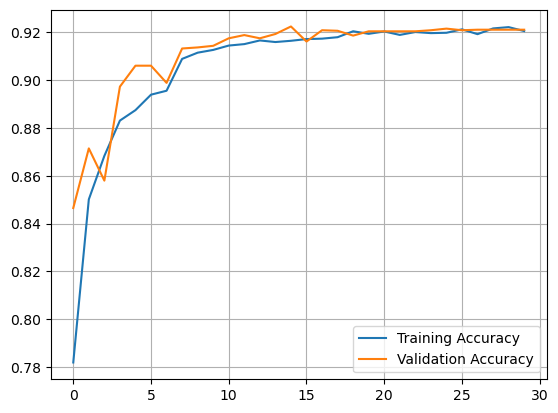

In [31]:
# vit
def plot_history_accuracy(history):
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_accuracy(history=history)

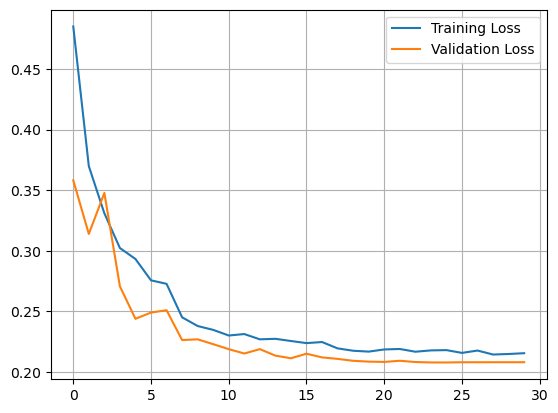

In [32]:
# vit
def plot_history_loss(history):
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

plot_history_loss(history=history)

In [87]:
# vit
predictions = model.predict(test_gen, steps=test_steps ,verbose = True)
predictions = (predictions >= 0.5).astype(int)

325/325 ━━━━━━━━━━━━━━━━━━━━ 196s 602ms/step


In [88]:
# Kiểm tra kích thước
print(f"Test labels shape: {test_labels.shape}")
print(f"Predictions shape: {predictions.shape}")

# Cắt cho khớp kích thước
min_length = min(len(test_labels), len(predictions))
test_labels = test_labels[:min_length]
predictions = predictions[:min_length]

print(f"After trimming - Test labels: {test_labels.shape}, Predictions: {predictions.shape}")

# Sau đó mới tính classification report
print(classification_report(test_labels, predictions, target_names=['Benign (Class 0)', 'Malignant (Class 1)']))

Test labels shape: (10381,)
Predictions shape: (10381, 1)
After trimming - Test labels: (10381,), Predictions: (10381, 1)
                     precision    recall  f1-score   support

   Benign (Class 0)       0.94      0.89      0.91      5250
Malignant (Class 1)       0.90      0.94      0.92      5131

           accuracy                           0.92     10381
          macro avg       0.92      0.92      0.92     10381
       weighted avg       0.92      0.92      0.92     10381



In [44]:
# Classification report dạng dict
report_dict = classification_report(
    test_labels, 
    predictions, 
    target_names=['Benign (Class 0)', 'Malignant (Class 1)'], 
    output_dict=True
)

# Chuyển thành DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# In ra bảng trong notebook
print(report_df)

# Lưu ra file CSV
report_df.to_csv("classification_report_version2.csv", index=True)
print("Classification report đã được lưu vào classification_report.csv")

                     precision    recall  f1-score       support
Benign (Class 0)      0.945639  0.904571  0.924650   5250.000000
Malignant (Class 1)   0.906512  0.946794  0.926215   5131.000000
accuracy              0.925441  0.925441  0.925441      0.925441
macro avg             0.926076  0.925683  0.925432  10381.000000
weighted avg          0.926300  0.925441  0.925424  10381.000000
Classification report đã được lưu vào classification_report.csv


325/325 ━━━━━━━━━━━━━━━━━━━━ 263s 811ms/step

ROC Analysis:
y_test shape for ROC: (10381,)
y_pred_prob shape: (10381,)


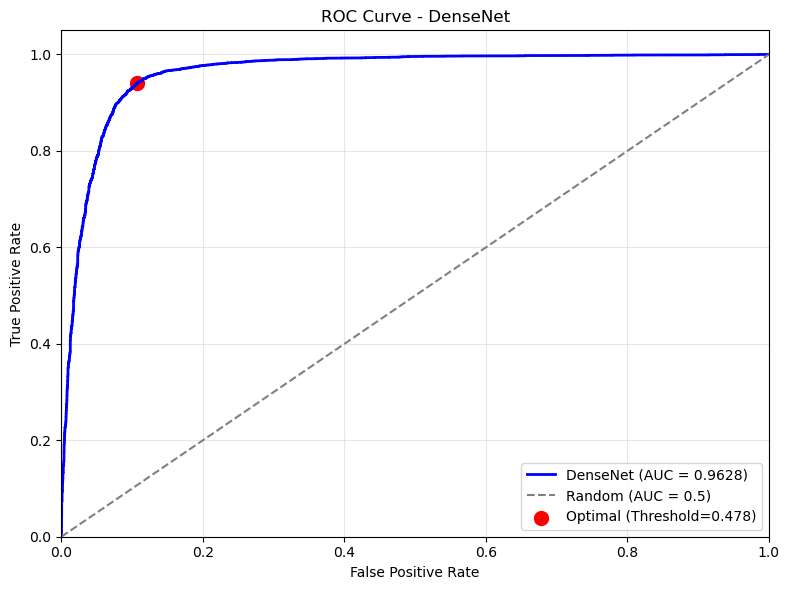

In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_curve, auc

# 1. Lấy predictions probabilities (chưa threshold)
# Đảm bảo dùng model.predict lại để lấy xác suất
y_pred_prob = model.predict(test_gen, steps=test_steps, verbose=True)

# 2. Flatten nếu cần
if len(y_pred_prob.shape) > 1 and y_pred_prob.shape[1] == 1:
    y_pred_prob = y_pred_prob.ravel()

# 3. Cắt cho khớp với test_labels (giống như bạn đã làm với predictions)
min_length = min(len(test_labels), len(y_pred_prob))
y_test_roc = test_labels[:min_length].copy()  # Tạo bản sao để không ảnh hưởng biến cũ
y_pred_prob = y_pred_prob[:min_length]

print(f"\nROC Analysis:")
print(f"y_test shape for ROC: {y_test_roc.shape}")
print(f"y_pred_prob shape: {y_pred_prob.shape}")

# 4. Tính ROC curve
fpr, tpr, thresholds = roc_curve(y_test_roc, y_pred_prob)
roc_auc = auc(fpr, tpr)

# 5. Tìm điểm tối ưu (Youden's J)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_idx]
optimal_fpr = fpr[youden_idx]
optimal_tpr = tpr[youden_idx]

# 6. Vẽ ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'DenseNet (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random (AUC = 0.5)')
plt.scatter(optimal_fpr, optimal_tpr, color='red', s=100, 
           label=f'Optimal (Threshold={optimal_threshold:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - DenseNet')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 7. Lưu ROC data vào CSV
roc_points_df = pd.DataFrame({
    'FPR': fpr,
    'TPR': tpr,
    'Threshold': thresholds
})
roc_points_df.to_csv('vit_ROC_curve_points.csv', index=False)

In [63]:
# vit
cm = confusion_matrix(test_labels,predictions)
cm

array([[4747,  503],
       [ 270, 4861]], dtype=int64)

In [64]:
cm = pd.DataFrame(cm, index=['0', '1'], columns=['0', '1'])

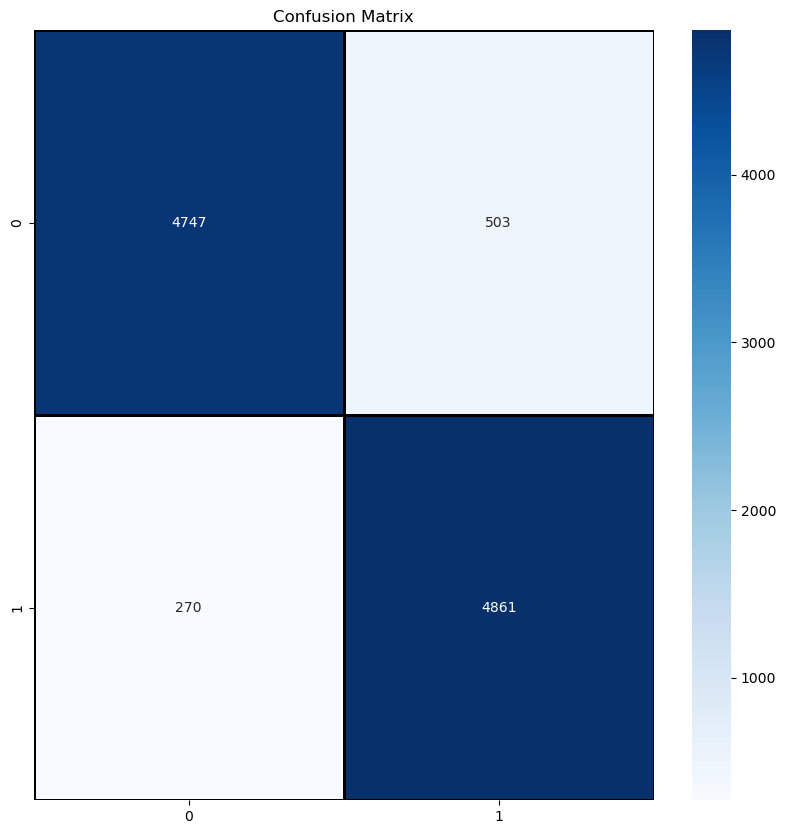

In [65]:
# vit
plt.figure(figsize=(10, 10))
sns.heatmap(cm, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='d', xticklabels=cm.columns, yticklabels=cm.index)
plt.title('Confusion Matrix')
plt.show()

In [29]:
# # # load the best weights
# model.load_weights('vit_pneumonia_weights.best.weights.h5')

In [ ]:
import keras_tuner as kt
import tensorflow as tf
from keras.src.layers import Layer, LayerNormalization, MultiHeadAttention, Dense, Dropout
from keras import Sequential
from keras import Model
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Input

# def __init__(self, num_classes, num_layers= 8, num_heads= 6, D=64, mlp_dim= 256, patch_size= 4, image_size= 28, dropout= 0.1, norm_eps= 1e-12):

# Define your ViT model function to use hyperparameters
def build_vit_model(hp):
    # Hyperparameters
    num_classes = 1  
    num_layers = hp.Int('num_layers', min_value=4, max_value=12, step=2)
    num_heads = hp.Int('num_heads', min_value=4, max_value=12, step=2)
    D = hp.Int('D', min_value=32, max_value=768, step=32)
    mlp_dim = hp.Int('mlp_dim', min_value=128, max_value=2048, step=128)
    patch_size = hp.Int('patch_size', min_value=4, max_value=16, step=4)
    image_size = 32
    dropout = hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    norm_eps = 1e-12

    img_size = image_size
    channel = 3
    train_batch_size= TRAIN_BATCH_SIZE
    valid_test_batch_size= VALID_TEST_BATCH_SIZE
    
    inputs = Input(shape=(img_size, img_size, channel)) 
    vit_model = ViT(num_classes=num_classes,
                num_layers=num_layers,
                num_heads=num_heads,
                D=D,
                mlp_dim=mlp_dim,
                patch_size=patch_size,
                image_size=image_size,
                dropout=dropout,
                norm_eps=norm_eps)
    
    outputs = vit_model(inputs)  
    
    model = Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')
    weight_decay = hp.Float('weight_decay', min_value=1e-6, max_value=1e-2, sampling='log')

    
    optimizer = kr.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
      )

    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )
    
    return model

# Create the Hyperband tuner
tuner = kt.Hyperband(
    build_vit_model,  # The model-building function
    objective='val_accuracy',  # The objective to optimize
    directory='best_hypter_parameter',  # Directory to store the results
    project_name='vit_tuning'  # Name of the project,
)

# Run the search for the best hyperparameters
tuner.search(train_gen,
            steps_per_epoch=train_steps,
            validation_data=valid_gen,
            validation_steps=validation_steps,
            epochs=100,
            callbacks=callbacks_list
           )

# Get the best model and hyperparameters
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best hyperparameters: {best_hp.values}")

Trial 89 Complete [00h 41m 22s]
val_accuracy: 0.8094382286071777

Best val_accuracy So Far: 0.8993258476257324
Total elapsed time: 4d 04h 44m 18s

Search: Running Trial #90

Value             |Best Value So Far |Hyperparameter
8                 |6                 |num_layers
8                 |12                |num_heads
512               |416               |D
1408              |1536              |mlp_dim
8                 |8                 |patch_size
0.5               |0.2               |dropout
0.0018834         |3.4021e-05        |learning_rate
4.7882e-06        |0.0010747         |weight_decay
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
 963/1082 ━━━━━━━━━━━━━━━━━━━━ 3:08 2s/step - accuracy: 0.5362 - loss: 1.0742